제시된 여행 보험 예측 데이터에서 TravelInsurance(여행보험 패키지를 구매 했는지 여부) 를 예측하는 모델을 개발하고

모델 개발 과정과 테스트 데이터셋에 대한 auc 를 답안으로 작성하시오

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, auc
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

### 데이터 읽기 및 확인

In [2]:
df = pd.read_csv("./data/travel_insurance_prediction.csv")

In [3]:
df.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


In [4]:
df.shape

(1987, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Age                  1987 non-null   int64 
 1   Employment Type      1987 non-null   object
 2   GraduateOrNot        1987 non-null   object
 3   AnnualIncome         1987 non-null   int64 
 4   FamilyMembers        1987 non-null   int64 
 5   ChronicDiseases      1987 non-null   int64 
 6   FrequentFlyer        1987 non-null   object
 7   EverTravelledAbroad  1987 non-null   object
 8   TravelInsurance      1987 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 139.8+ KB


In [6]:
df.describe()

,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance
count,1987.000000,1.987000e+03,1987.000000,1987.000000,1987.000000
mean,29.650226,9.327630e+05,4.752894,0.277806,0.357323
std,2.913308,3.768557e+05,1.609650,0.448030,0.479332
min,25.000000,3.000000e+05,2.000000,0.000000,0.000000
25%,28.000000,6.000000e+05,4.000000,0.000000,0.000000
50%,29.000000,9.000000e+05,5.000000,0.000000,0.000000
75%,32.000000,1.250000e+06,6.000000,1.000000,1.000000
max,35.000000,1.800000e+06,9.000000,1.000000,1.000000


In [7]:
df["Employment Type"].value_counts()

Employment Type
Private Sector/Self Employed    1417
Government Sector                570
Name: count, dtype: int64

In [8]:
df["GraduateOrNot"].value_counts()

GraduateOrNot
Yes    1692
No      295
Name: count, dtype: int64

In [9]:
df["FrequentFlyer"].value_counts()

FrequentFlyer
No     1570
Yes     417
Name: count, dtype: int64

In [10]:
df["EverTravelledAbroad"].value_counts()

EverTravelledAbroad
No     1607
Yes     380
Name: count, dtype: int64

# 데이터 전처리

### 인트 타입으로 변경

- GraduateOrNot
- FrequentFlyer
- EverTravelledAbroad

In [11]:
df["GraduateOrNot"] = df["GraduateOrNot"].map(lambda x: 1 if x == "Yes" else 0)
df["FrequentFlyer"] = df["FrequentFlyer"].map(lambda x: 1 if x == "Yes" else 0)
df["EverTravelledAbroad"] = df["EverTravelledAbroad"].map(lambda x: 1 if x == "Yes" else 0)

### 오브젝트 피처 범주화

In [12]:
ndf = df.copy()

In [13]:
ndf.drop(["Employment Type"], axis = 1)

,Age,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,1,400000,6,1,0,0,0
1,31,1,1250000,7,0,0,0,0
2,34,1,500000,4,1,0,0,1
3,28,1,700000,3,1,0,0,0
4,28,1,700000,8,1,1,0,0
...,...,...,...,...,...,...,...,...
1982,33,1,1500000,4,0,1,1,1
1983,28,1,1750000,5,1,0,1,0
1984,28,1,1150000,6,1,0,0,0
1985,34,1,1000000,6,0,1,1,1


In [14]:
pd.get_dummies(ndf[["Employment Type"]], dtype = int)

,Employment Type_Government Sector,Employment Type_Private Sector/Self Employed
0,1,0
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
1982,0,1
1983,0,1
1984,0,1
1985,0,1


In [15]:
ndf = pd.concat([ndf.drop(["Employment Type"], axis = 1), 
           pd.get_dummies(ndf[["Employment Type"]], dtype = int)],
         axis = 1)

In [16]:
ndf.head()

,Age,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance,Employment Type_Government Sector,Employment Type_Private Sector/Self Employed
0,31,1,400000,6,1,0,0,0,1,0
1,31,1,1250000,7,0,0,0,0,0,1
2,34,1,500000,4,1,0,0,1,0,1
3,28,1,700000,3,1,0,0,0,0,1
4,28,1,700000,8,1,1,0,0,0,1


### 데이터 분할

In [17]:
x = ndf.drop("TravelInsurance", axis = 1)
y = ndf["TravelInsurance"]

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, stratify = y, random_state = 7)

### 스케일링 적용 (Age, AnnualIncome, FamilyMembers)

In [19]:
scaled_cols = ["Age", "AnnualIncome", "FamilyMembers"]
ss = StandardScaler()
scaled_train = pd.DataFrame(ss.fit_transform(x_train[scaled_cols]), columns = scaled_cols)
scaled_test = pd.DataFrame(ss.transform(x_test[scaled_cols]), columns = scaled_cols)

In [20]:
scaled_train = pd.concat([scaled_train, x_train.drop(scaled_cols, axis = 1).reset_index(drop = True)], axis = 1)
scaled_test = pd.concat([scaled_test, x_test.drop(scaled_cols, axis = 1).reset_index(drop = True)], axis = 1)

In [21]:
scaled_train.head()

,Age,AnnualIncome,FamilyMembers,GraduateOrNot,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,Employment Type_Government Sector,Employment Type_Private Sector/Self Employed
0,0.449903,-1.561315,-1.094980,0,0,0,0,1,0
1,-0.587798,-0.629387,1.367692,1,0,1,0,0,1
2,-0.587798,-1.028785,0.136356,0,0,0,0,0,1
3,-0.933699,0.302542,0.136356,1,0,0,0,1,0
4,-0.587798,-1.028785,2.599027,1,0,0,0,0,1


### 언더샘플링 시도

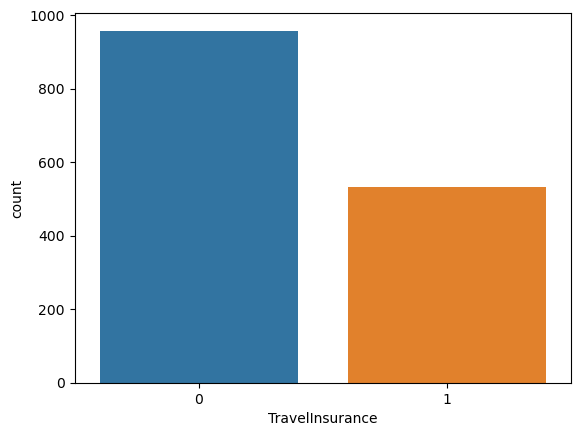

In [22]:
sns.countplot(x = "TravelInsurance", data = pd.DataFrame(y_train))
plt.show()

In [23]:
y_train.value_counts()

TravelInsurance
0    958
1    532
Name: count, dtype: int64

In [24]:
x_train_under, y_train_under = RandomUnderSampler(random_state = 7).fit_resample(scaled_train, y_train)

In [25]:
x_train_under.shape

(1064, 9)

In [26]:
y_train_under.value_counts()

TravelInsurance
0    532
1    532
Name: count, dtype: int64

### 로지스틱 회귀 시도

In [27]:
logi = LogisticRegression()

In [28]:
logi.fit(x_train_under, y_train_under)

LogisticRegression()

In [29]:
print(logi.score(x_train_under, y_train_under))
print(logi.score(scaled_test, y_test))

0.7189849624060151
0.7404426559356136


In [30]:
roc_auc_score(y_test, logi.predict_proba(scaled_test)[:, 1])

0.7562431756542567

### 언더샘플링 없이 로지스틱 회귀 시도

In [31]:
logi.fit(scaled_train, y_train)

LogisticRegression()

In [32]:
print(logi.score(scaled_train, y_train))
print(logi.score(scaled_test, y_test))

0.7758389261744967
0.7645875251509054


In [33]:
roc_auc_score(y_test, logi.predict_proba(scaled_test)[:, 1])

0.7555035046317495

### 랜덤포레스트 시도

In [34]:
rf = RandomForestClassifier()

In [35]:
rf.fit(x_train, y_train)

RandomForestClassifier()

In [36]:
print(rf.score(x_train, y_train))
print(rf.score(x_test, y_test))

0.9288590604026845
0.8028169014084507


In [37]:
roc_auc_score(y_test, rf.predict_proba(x_test)[:, 1])

0.7958772146102637

### 엑스트라트리 시도

In [38]:
et = ExtraTreesClassifier()

In [39]:
et.fit(x_train, y_train)

ExtraTreesClassifier()

In [40]:
print(et.score(x_train, y_train))
print(et.score(x_test, y_test))

0.9288590604026845
0.7887323943661971


In [41]:
roc_auc_score(y_test, et.predict_proba(x_test)[:, 1])

0.776531295128738

### 그레디언트 부스팅 시도

In [42]:
gb = GradientBoostingClassifier(random_state = 7, n_estimators = 200, learning_rate = 0.1)

In [43]:
gb.fit(x_train, y_train)

GradientBoostingClassifier(n_estimators=200, random_state=7)

In [44]:
print(gb.score(x_train, y_train))
print(gb.score(x_test, y_test))

0.8543624161073825
0.8430583501006036


In [45]:
roc_auc_score(y_test, gb.predict_proba(x_test)[:, 1])

0.8259483639181431

# 교차검증 시도

### 로지스틱 - 교차검증

In [46]:
ss_x = ss.fit_transform(x)

In [47]:
logi.fit(ss_x, y)

LogisticRegression()

In [48]:
scores = cross_validate(logi, ss_x, y, return_train_score = True, scoring="roc_auc", n_jobs = -1)
scores["test_score"].mean()

0.7639288611571389

### 랜덤포레스트 - 교차검증

In [49]:
rf.fit(x, y)

RandomForestClassifier()

In [50]:
scores = cross_validate(rf, ss_x, y, return_train_score = True, scoring="roc_auc", n_jobs = -1)
scores["test_score"].mean()

0.7910946885356257

### 엑스트라 트리 - 교차검증

In [51]:
et.fit(x, y)

ExtraTreesClassifier()

In [52]:
scores = cross_validate(et, ss_x, y, return_train_score = True, scoring="roc_auc", n_jobs = -1)
scores["test_score"].mean()

0.7609845454466998

### 그래디언트 부스팅 - 교차검증

In [53]:
gb.fit(x, y)

GradientBoostingClassifier(n_estimators=200, random_state=7)

In [54]:
scores = cross_validate(gb, ss_x, y, return_train_score = True, scoring="roc_auc", n_jobs = -1)
scores["test_score"].mean()

0.8003738715996962